In [15]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm
import pandas as pd

import itertools
from scipy.spatial.distance import pdist


Staramy się poprawić zaimplementowane wcześniej algorytmy. Należy zaproponować dowolną
modyfikację zaimplementowanych wcześniej algorytmów lub zupełnie nową metodę, która pozwoli
poprawić średni wynik i najlepszy wynik uzyskany we wcześniejszych eksperymentach (na obu
instancjach) w tym samym czasie. Nowy algorytm należy dokładnie opisać. Można wykorzystać np.
takie mechanizmy jak:
- generowanie lepszych rozwiązań startowych,
- dalsze poprawa efektywności lokalnego przeszukiwania,
- globalna pamięć ocen ruchów,
- nowe mechanizmy ruchów kandydackich,
- inne operatory sąsiedztwa, perturbacji, rekombinacji,
- jednoczesne wykorzystanie różnych operatorów,
- wykorzystanie mechanizmów maszynowego uczenia,

In [197]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [5]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    cycles={}
    cycles[0]=np.random.choice(100,50,replace=False)
    cycles[1]=np.array([i for i in np.arange(0,100,1) if i not in cycles[0]])
    np.random.shuffle(cycles[1])
    return cycles


In [146]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [147]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [7]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges", cycles=None):
    #specify cycles initialization.
    if cycles is None:
        if init_random:
            cycles = start_cycle_random()
        else:
            cycles = start_cycle_heuristic()
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    #print(cycles[0])
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance

In [215]:
def plot(dataset, cycles):
    plt.clf()
#     plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#     plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][0]]], dataset[:,1][[*cycles[1],cycles[1][0]]], "->")
#     plt.savefig(f"Genetic_LS-{DOLS}_{dataset_choice}.png")
    plt.show()

In [151]:
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [190]:
def kMeans(data, k=2, maxIteration=200, epsilon=0.0001, randomCentroid=False):
    
    #select centroids
    if randomCentroid:
        minC = np.min(data)
        maxC = np.max(data)
        centroids = np.zeros( (k, data.shape[1]) )
        for i in range(len(centroids)):
            centroids[i] = np.random.uniform(low=minC, high=maxC, size=(data.shape[1],))
    else:
        Npoints = k
        c = [list(x) for x in itertools.combinations(range(len(data)), Npoints )]
        distances = []
        for i in c:    
            distances.append(np.mean(pdist(data[i,:]))) # pdist: a method of computing all pairwise Euclidean distances in a condensed way.

        ind = distances.index(max(distances)) # finding the index of the max mean distance
        rows = c[ind] # these are the points in question
        centroids = data[rows]
#     print(centroids)
    
    for epoch in range(maxIteration):        
        #iterattion of k-means
        clusterList = np.zeros(len(data))
        for iRow, row in enumerate(data):
            minDist = np.inf
            cluster = 0
            counter_0_Cluster = 0
            counter_1_Cluster = 0
            for i,centroid in enumerate(centroids):
                dist = np.linalg.norm(row-centroid)
                if dist < minDist:
                    minDist = dist
                    cluster = i
            clusterList[iRow] = cluster
        clusterList = np.array(clusterList)
        # check for equal division
        counter0 = np.where(clusterList==0)[0].shape[0]
        counter1 = np.where(clusterList==1)[0].shape[0]
        if counter0 > counter1:
            howManyTake = (counter0 - counter1) / 2
            distances = {}
            for index in np.where(clusterList==0)[0]:
                dist = np.linalg.norm(data[index]-centroids[1])
                distances[index] = dist
            
            distances = [k for k, v in sorted(distances.items(), key=lambda item: item[1])]
            for _, index in zip(range(int(howManyTake)), distances):
                clusterList[index] = 1
        elif counter0 < counter1:
            howManyTake = (counter1 - counter0) / 2
            distances = {}
            for index in np.where(clusterList==1)[0]:
                dist = np.linalg.norm(data[index]-centroids[0])
                distances[index] = dist
            distances = [k for k, v in sorted(distances.items(), key=lambda item: item[1])]
            for _, index in zip(range(int(howManyTake)), distances):
                clusterList[index] = 0
            
        #calc new centroids
        
        doBreak = True
        for i in range(len(centroids)):
            newValue  = np.mean(data[clusterList==i], axis=0)                   
            if (clusterList==i).any():
              #  print(f"data[clusterList==i] {data[clusterList==i]}")
              #  print(f"newValue: {newValue}")
                if (np.abs(newValue - centroids[i]) > epsilon).any():
                    doBreak = False
                centroids[i] = newValue
        if doBreak:
            print("Change smaller than epsilon: break")
            break
#     print(f"Performed {epoch} iteration of kMeans")
    cycles = {0: np.argwhere(clusterList==0)[:,0], 1: np.argwhere(clusterList==1)[:,0]}
    return cycles

In [217]:
def kMeansHeuristic(dataset, dist, np_dots):
    cycles = kMeans(dataset)
#     plot(dataset, cycles)
    internal_change = change_edges
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist)
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance

  2%|▏         | 1/50 [00:10<08:41, 10.64s/it]

newBestDistance 25390.48524770619


  4%|▍         | 2/50 [00:21<08:48, 11.00s/it]

newBestDistance 25332.214418596566


  6%|▌         | 3/50 [00:35<09:39, 12.32s/it]

newBestDistance 24518.26954623305


 10%|█         | 5/50 [01:01<09:40, 12.89s/it]

newBestDistance 23265.045611836504


100%|██████████| 50/50 [09:23<00:00, 11.28s/it]

newBestDistance 22320.036811269616
krob100
24537(22320-26170)


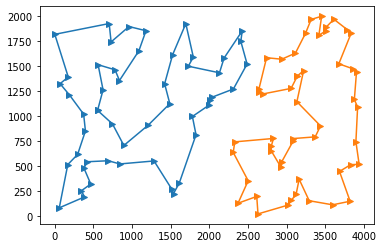

distance: 22320.036811269616


In [226]:
dist = distb
dataset = np_krob
bestCycles = None
bestDistance = np.inf
distanceTable = []
for x in tqdm(range(50)):
    cycles, distance = kMeansHeuristic(dataset, dist, dataset)
    distanceTable.append(distance)
    if distance < bestDistance:
        print(f"newBestDistance {distance}")
        bestDistance = distance 
        bestCycles = cycles      

print("krob100")        
print(f"{int(np.mean(distanceTable))}({int(np.min(distanceTable))}-{int(np.max(distanceTable))})")
plot(dataset, bestCycles)
print(f"distance: {bestDistance}")

  2%|▏         | 1/50 [00:12<10:04, 12.34s/it]

newBestDistance 21853.20760013614


 60%|██████    | 30/50 [05:27<03:33, 10.68s/it]

newBestDistance 21830.99140788301


100%|██████████| 50/50 [09:08<00:00, 10.96s/it]

kroa100
23158(21830-24838)


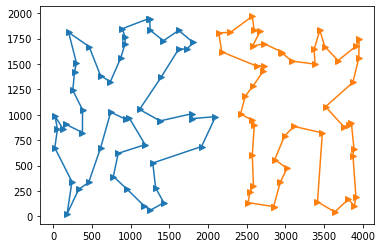

distance: 21830.99140788301


In [227]:
dist = dista
dataset = np_kroa
bestCycles = None
bestDistance = np.inf
distanceTable = []
for x in tqdm(range(50)):
    cycles, distance = kMeansHeuristic(dataset, dist, dataset)
    distanceTable.append(distance)
    if distance < bestDistance:
        print(f"newBestDistance {distance}")
        bestDistance = distance 
        bestCycles = cycles      

print("kroa100")        
print(f"{int(np.mean(distanceTable))}({int(np.min(distanceTable))}-{int(np.max(distanceTable))})")
plot(dataset, bestCycles)
print(f"distance: {bestDistance}")

In [228]:
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

  2%|▏         | 1/50 [02:17<1:51:55, 137.06s/it]

newBestDistance 34011.502905127505


  8%|▊         | 4/50 [08:59<1:43:30, 135.01s/it]

newBestDistance 33532.94315582453


 10%|█         | 5/50 [11:02<1:38:09, 130.87s/it]

newBestDistance 33174.84982709347


 12%|█▏        | 6/50 [13:00<1:32:45, 126.50s/it]

newBestDistance 32624.7272615198


 14%|█▍        | 7/50 [14:48<1:26:12, 120.29s/it]

newBestDistance 31950.38186450034


 60%|██████    | 30/50 [1:09:04<46:43, 140.17s/it]

newBestDistance 31608.324550557976


 94%|█████████▍| 47/50 [1:48:06<06:48, 136.13s/it]

newBestDistance 31384.082505115253


100%|██████████| 50/50 [1:55:20<00:00, 138.42s/it]


kroa200
33108(31384-34608)


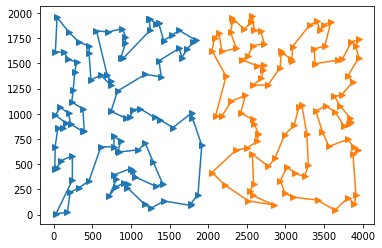

distance: 31384.082505115253


In [229]:
dist = dista
dataset = np_kroa
bestCycles = None
bestDistance = np.inf
distanceTable = []
for x in tqdm(range(50)):
    cycles, distance = kMeansHeuristic(dataset, dist, dataset)
    distanceTable.append(distance)
    if distance < bestDistance:
        print(f"newBestDistance {distance}")
        bestDistance = distance 
        bestCycles = cycles      

print("kroa200")        
print(f"{int(np.mean(distanceTable))}({int(np.min(distanceTable))}-{int(np.max(distanceTable))})")
plot(dataset, bestCycles)
print(f"distance: {bestDistance}")

  2%|▏         | 1/50 [02:46<2:15:51, 166.37s/it]

newBestDistance 33255.20908075371


  8%|▊         | 4/50 [09:50<1:50:39, 144.34s/it]

newBestDistance 32971.75456814347


 26%|██▌       | 13/50 [30:56<1:24:03, 136.32s/it]

newBestDistance 32123.388520247285


100%|██████████| 50/50 [1:38:04<00:00, 117.68s/it]

krob200
33386(32123-34573)


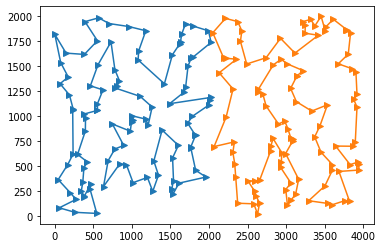

distance: 32123.388520247285


In [230]:
dist = distb
dataset = np_krob
bestCycles = None
bestDistance = np.inf
distanceTable = []
for x in tqdm(range(50)):
    cycles, distance = kMeansHeuristic(dataset, dist, dataset)
    distanceTable.append(distance)
    if distance < bestDistance:
        print(f"newBestDistance {distance}")
        bestDistance = distance 
        bestCycles = cycles      

print("krob200")        
print(f"{int(np.mean(distanceTable))}({int(np.min(distanceTable))}-{int(np.max(distanceTable))})")
plot(dataset, bestCycles)
print(f"distance: {bestDistance}")